In [45]:
import pandas as pd
import numpy as np
from models.debug_pipeline import DebugStep
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV, ParameterSampler
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report, roc_auc_score, ConfusionMatrixDisplay, precision_recall_fscore_support, balanced_accuracy_score, classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.decomposition import PCA
from sklearn.utils import resample
import shap
import matplotlib.pyplot as plt


In [46]:
# Charger les données
data = pd.read_csv('../data/processed/merged_data_2019_2022.csv')


In [47]:
# Séparer les données en caractéristiques (X) et cible (y)
X = data.drop(columns=['grav'])
y = data['grav']

# Etiqueter les classes de 0 à 2
y = y - 1

# Diviser en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Taille du resample
TARGET_SAMPLE_SIZE = y_train.value_counts().min()
print(TARGET_SAMPLE_SIZE)

# Identifier les colonnes numériques et catégoriques
categorical_columns = X_train.select_dtypes(include=['object']).columns
numerical_columns = X_train.select_dtypes(include=['int64', 'float64']).columns

# Pipeline pour les colonnes catégoriques
categorical_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore', drop='first')),
])

# Pipeline pour les colonnes numériques
numerical_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', MinMaxScaler())
])

# Combinaison des pipelines dans un ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_pipeline, numerical_columns),
        ('cat', categorical_pipeline, categorical_columns)
    ]
)


10429


In [48]:
pipeline_rf = ImbPipeline(steps= [
    ('preprocessor', preprocessor),
    ('smote', SMOTE(sampling_strategy='not majority', random_state=42)),
    ('undersample', RandomUnderSampler(sampling_strategy="not minority", random_state=42)),
    ('classifier', RandomForestClassifier(random_state=42))
])

param_grid_rf = {
    'classifier__n_estimators': [100, 200, 300],
    'classifier__max_depth': [10, None],
    'classifier__min_samples_split': [2, 5],
    'classifier__min_samples_leaf': [1, 2]
}

random_search = RandomizedSearchCV(
    pipeline_rf, 
    param_distributions=param_grid_rf, 
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    scoring='balanced_accuracy', 
    n_iter=10, 
    random_state=42, 
    n_jobs=-1
)

random_search.fit(X_train, y_train)
print("Meilleurs paramètres :", random_search.best_params_)


Meilleurs paramètres : {'classifier__n_estimators': 300, 'classifier__min_samples_split': 5, 'classifier__min_samples_leaf': 2, 'classifier__max_depth': 10}


In [49]:
y_pred = random_search.best_estimator_.predict(X_test)
print(f"Balanced Accuracy (test): {balanced_accuracy_score(y_test, y_pred):.4f}")
print("Rapport de classification (test) :")
print(classification_report(y_test, y_pred))

Balanced Accuracy (test): 0.5853
Rapport de classification (test) :
              precision    recall  f1-score   support

           0       0.93      0.76      0.84     80708
           1       0.14      0.51      0.22      2607
           2       0.32      0.48      0.39     15173

    accuracy                           0.71     98488
   macro avg       0.46      0.59      0.48     98488
weighted avg       0.81      0.71      0.75     98488



In [50]:
# Rapport des performances
test_balanced_accuracy = balanced_accuracy_score(y_test, y_pred)
print(f"Balanced Accuracy (test): {test_balanced_accuracy:.4f}")
print("Rapport de classification (test) :")
print(classification_report(y_test, y_pred))

# Matrice de confusion
conf_matrix = confusion_matrix(y_test, y_pred)
print("Matrice de confusion :")
print(conf_matrix)

Balanced Accuracy (test): 0.5853
Rapport de classification (test) :
              precision    recall  f1-score   support

           0       0.93      0.76      0.84     80708
           1       0.14      0.51      0.22      2607
           2       0.32      0.48      0.39     15173

    accuracy                           0.71     98488
   macro avg       0.46      0.59      0.48     98488
weighted avg       0.81      0.71      0.75     98488

Matrice de confusion :
[[61705  4431 14572]
 [  518  1326   763]
 [ 4227  3620  7326]]


In [51]:
print(pipeline_rf)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  Index(['jour', 'mois', 'hr', 'vma', 'an_nais', 'nb_v', 'nb_u', 'has_ceinture',
       'has_gants', 'has_casque', 'has_airbag', 'has_gilet', 'has_de',
       'choc_avant', 'choc_arriere', 'choc_gauche', 'choc_droit'],
      dtype='object')),
                                                 ('ca...
                                                  Index(['lum', 'agg', 'int', 'atm', 'col', 'catr', 'circ', 'vosp', 'prof',
       'plan', 'surf', 'infra', 'situ', 'place', 'sexe', 'trajet', 'locp',
       'senc', 'catv', 'obs', 'obsm']


=== Fold 1 ===
Après UnderSampler :
grav
0    8343
1    8343
2    8343
Name: count, dtype: int64


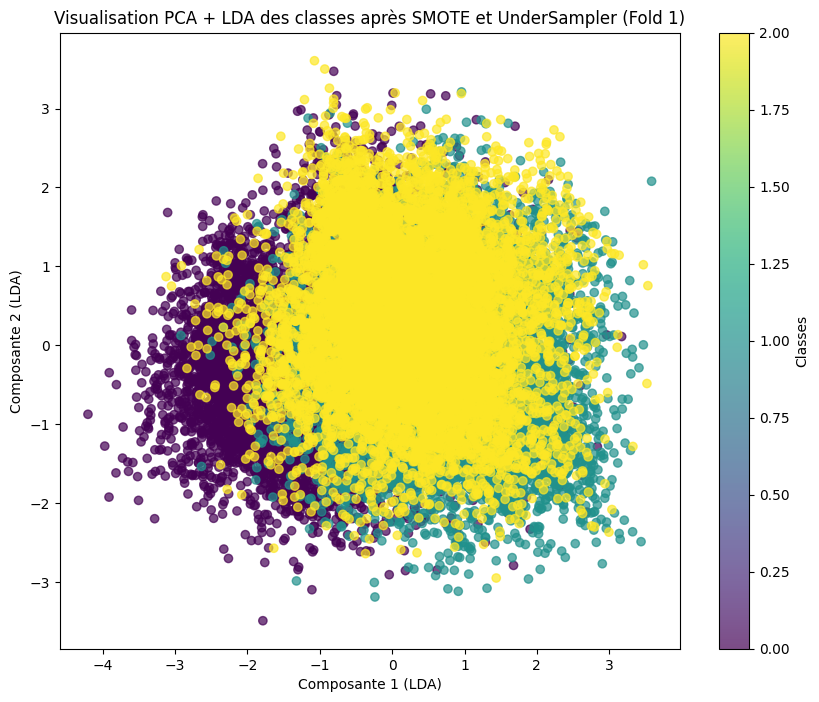


=== Fold 2 ===
Après UnderSampler :
grav
0    8343
1    8343
2    8343
Name: count, dtype: int64


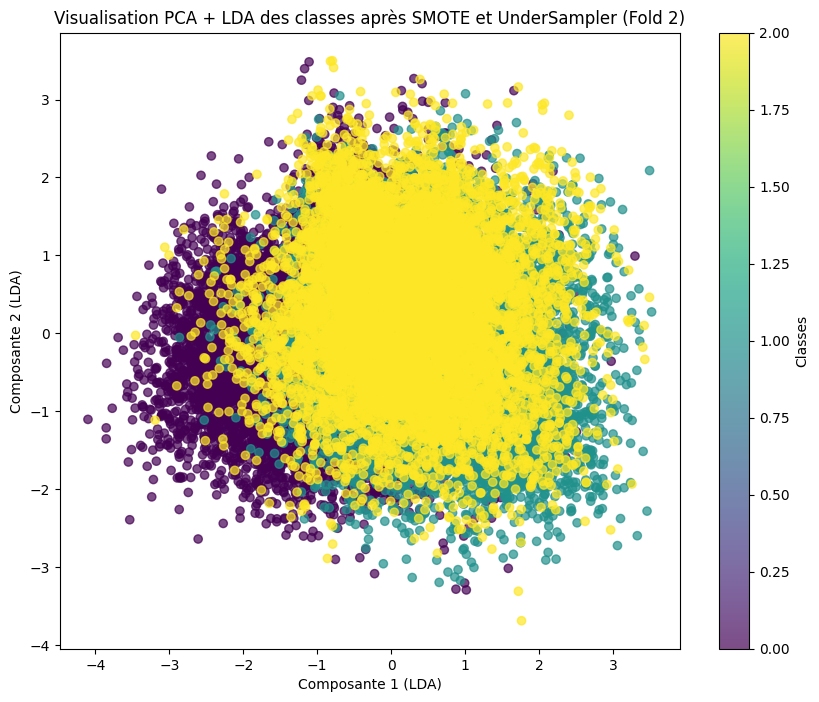


=== Fold 3 ===
Après UnderSampler :
grav
0    8344
1    8344
2    8344
Name: count, dtype: int64


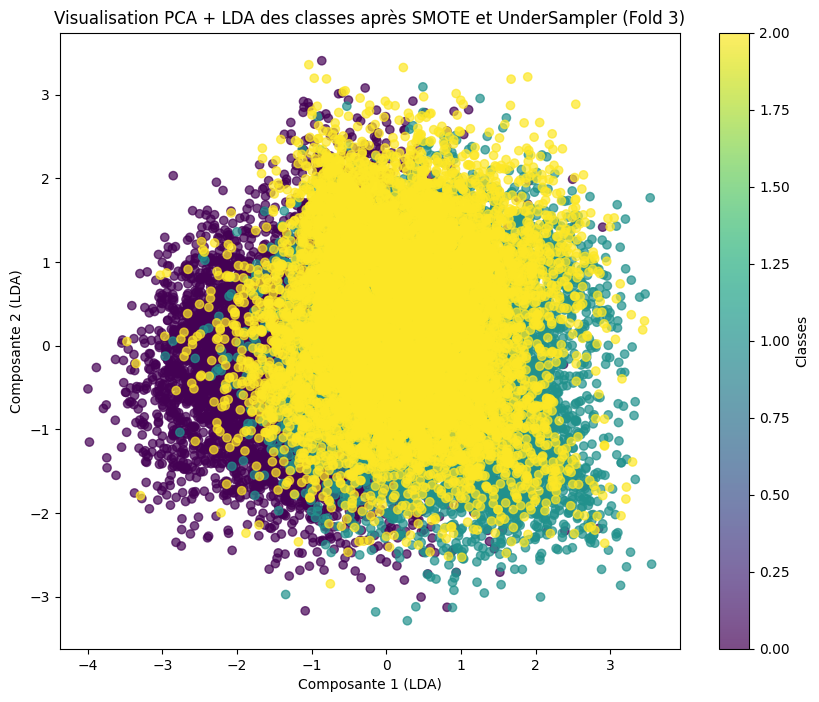


=== Fold 4 ===
Après UnderSampler :
grav
0    8343
1    8343
2    8343
Name: count, dtype: int64


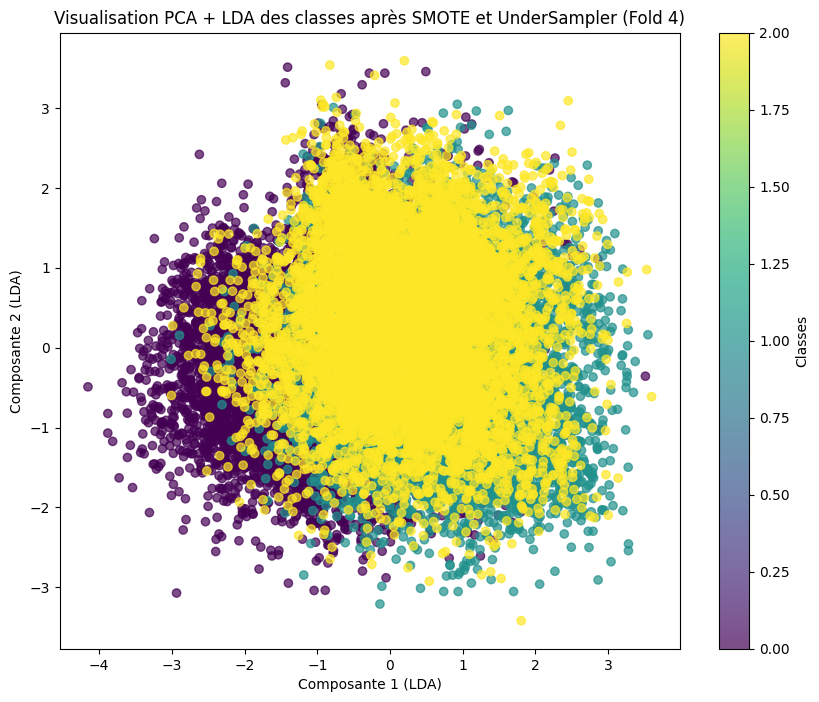


=== Fold 5 ===
Après UnderSampler :
grav
0    8343
1    8343
2    8343
Name: count, dtype: int64


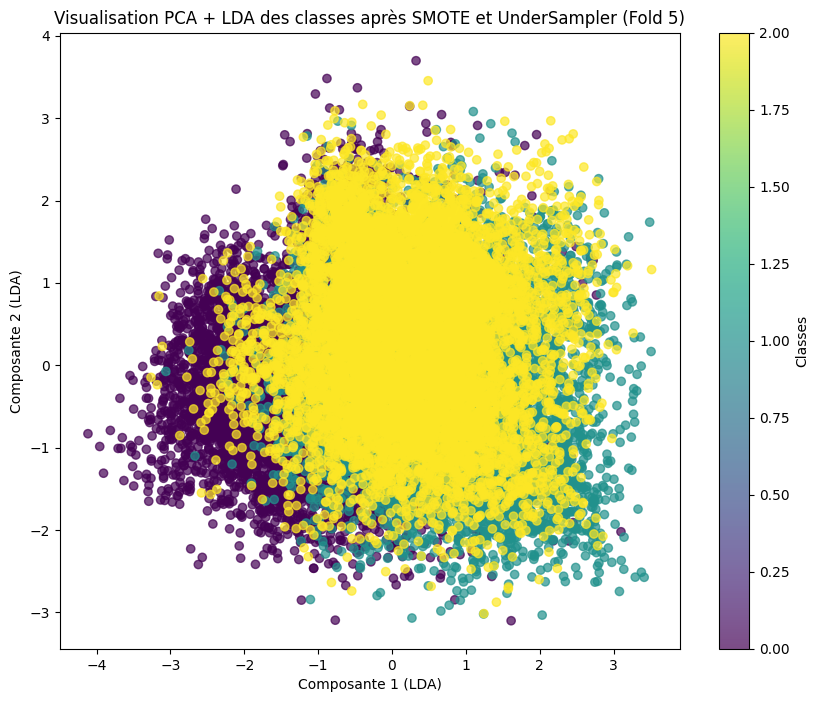

In [52]:
# Configuration des rééquilibrages
smote = SMOTE(sampling_strategy="not majority", random_state=42)
undersample = RandomUnderSampler(sampling_strategy="not minority", random_state=42)

# Configuration de StratifiedKFold
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Itérer sur les folds pour vérifier l'équilibrage des classes
for fold, (train_idx, val_idx) in enumerate(cv.split(X_train, y_train)):
    print(f"\n=== Fold {fold + 1} ===")
    
    # Séparer les données pour ce fold
    X_fold_train, y_fold_train = X_train.iloc[train_idx], y_train.iloc[train_idx]
    
    # Appliquer l'encodage
    X_encoded_train = preprocessor.fit_transform(X_fold_train)
    
    # Appliquer SMOTE
    #X_smote, y_smote = smote.fit_resample(X_encoded_train, y_fold_train)
    #print("Après SMOTE :")
    #print(pd.Series(y_smote).value_counts())

    # Appliquer UnderSampler
    X_undersample, y_undersample = undersample.fit_resample(X_encoded_train, y_fold_train)
    print("Après UnderSampler :")
    print(pd.Series(y_undersample).value_counts())
    
    # Réduction des dimensions avec PCA
    pca = PCA(n_components=42, random_state=42)
    X_pca = pca.fit_transform(X_undersample)

    # Réduction des dimensions avec LDA
    lda = LinearDiscriminantAnalysis(n_components=2)  # Réduit à 2 dimensions
    X_lda = lda.fit_transform(X_pca, y_undersample)
    
    # Visualisation graphique
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(X_lda[:, 0], X_lda[:, 1], c=y_undersample, cmap='viridis', alpha=0.7)
    plt.colorbar(scatter, label="Classes")
    plt.title(f"Visualisation PCA + LDA des classes après SMOTE et UnderSampler (Fold {fold + 1})")
    plt.xlabel("Composante 1 (LDA)")
    plt.ylabel("Composante 2 (LDA)")
    plt.show()


In [53]:
# Features selection

from itertools import chain


X_train_transformed = preprocessor.fit_transform(X_train)

categorical_features = preprocessor.named_transformers_['cat'].named_steps['encoder'].get_feature_names_out(categorical_columns)
transformed_columns = list(chain(numerical_columns, categorical_features))
X_train_transformed_df = pd.DataFrame(X_train_transformed, columns=transformed_columns)

X_train_transformed_df['grav'] = y_train.reset_index(drop=True)

corr_matrix = X_train_transformed_df.corr()
corr_with_target = corr_matrix["grav"].abs().sort_values(ascending=False)

print("Corrélations absolues avec la variable cible (triées par ordre décroissant) :")
print(corr_with_target)

# Définir un seuil minimal de corrélation absolue
threshold = 0.05
selected_features = corr_with_target[corr_with_target > threshold].index.tolist()
print("Caractéristiques pertinentes sélectionnées :")
print(selected_features)

X_train_selected = X_train_transformed_df[selected_features]



Corrélations absolues avec la variable cible (triées par ordre décroissant) :
grav                      1.000000
has_ceinture              0.238117
has_casque                0.192407
catv_vl                   0.164515
obs_naturel               0.164391
agg_oui                   0.150867
nb_v                      0.148190
situ_particuliere         0.144102
obsm_vehicule             0.143495
has_gants                 0.136758
col_sans_collision        0.126844
plan_rectiligne           0.115574
place_pieton              0.109655
nb_u                      0.106516
locp_sans                 0.105204
obs_structurel            0.100879
locp_chaussee             0.095347
choc_arriere              0.095304
vma                       0.090747
trajet_professionnelle    0.089266
col_deux_vl               0.087352
trajet_personnelle        0.086033
choc_avant                0.072779
prof_plat                 0.065465
circ_simple               0.063437
int_simple                0.061178
an_nais     

In [54]:
# Calculer la matrice de corrélation pour les caractéristiques sélectionnées
corr_matrix_selected = X_train_selected.corr()

# Identifier les paires de colonnes ayant une corrélation élevée
high_corr_pairs = [
    (col1, col2, corr_matrix_selected.loc[col1, col2])
    for col1 in corr_matrix_selected.columns
    for col2 in corr_matrix_selected.columns
    if col1 < col2 and abs(corr_matrix_selected.loc[col1, col2]) > 0.9  # col1 < col2 évite les doublons
]

# Afficher les paires de colonnes fortement corrélées
print("Paires de colonnes fortement corrélées :")
for col1, col2, corr in high_corr_pairs:
    print(f"{col1} et {col2} : corrélation = {corr:.2f}")

# Définir les colonnes à supprimer (exemple : toujours supprimer la deuxième colonne)
columns_to_drop = set([col2 for col1, col2, corr in high_corr_pairs])
X_train_final = X_train_selected.drop(columns=columns_to_drop, axis=1)

# Afficher les colonnes finales
print("Colonnes finales après suppression des redondances :")
print(X_train_final.columns.tolist())


Paires de colonnes fortement corrélées :
locp_sans et place_pieton : corrélation = -0.96
locp_chaussee et locp_sans : corrélation = -0.93
Colonnes finales après suppression des redondances :
['grav', 'has_ceinture', 'has_casque', 'catv_vl', 'obs_naturel', 'agg_oui', 'nb_v', 'situ_particuliere', 'obsm_vehicule', 'has_gants', 'col_sans_collision', 'plan_rectiligne', 'nb_u', 'obs_structurel', 'locp_chaussee', 'choc_arriere', 'vma', 'trajet_professionnelle', 'col_deux_vl', 'trajet_personnelle', 'choc_avant', 'prof_plat', 'circ_simple', 'int_simple', 'an_nais', 'vosp_sans', 'catr_route_principale']
